In [24]:
import bagpy
import folium
import pandas as pd
from bagpy import bagreader
from geopy.distance import geodesic
from IPython.display import HTML, display
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import utm
import seaborn as sns
%matplotlib notebook
pd.set_option("display.precision", 12)
#
# Author: Nathaniel Hanson
# Date: 02/16/2021
# Purpose: Straight line path GPS analysis
#

In [25]:
line = bagreader('./record-line_2021-02-16-23-11-53.bag')
print(line.topic_table)
dataStat = pd.read_csv(line.message_by_topic('/gps_data'))

[INFO]  Data folder ./record-line_2021-02-16-23-11-53 already exists. Not creating.
      Topics            Types  Message Count       Frequency
0  /gps_data   gps_driver/GPS             97  3.276897282888
1  /raw_data  std_msgs/String            347  9.881901692336


In [28]:
# Plot locations on a map
m = folium.Map(
    location=[42.351944, -71.077415],
    max_zoom=20,
    zoom_start=19
)
temp = dataStat.apply(lambda row:folium.CircleMarker(location=[row["lat"], 
                                                  row["lon"]]).add_to(m),
         axis=1)
# Plot straight line from start path to end path
start = [42.352257, -71.076889]
end = dataStat.tail(1)[['lat', 'lon']].values[0]
# Interpolate a straight line
latInterp = np.linspace(start[0], end[0], len(dataStat))
lonInterp = np.linspace(start[1], end[1], len(dataStat))
joinInterp = list(zip(latInterp, lonInterp))
temp = [folium.CircleMarker(location=loc, color='red').add_to(m) for loc in joinInterp] 
display(m)

In [30]:
# Convert truth points to utm
utmInterp = [utm.from_latlon(*point)[0:2] for point in joinInterp]
# Add points to dataframe
dataStat['truth_east'] = [z[0] for z in utmInterp]
dataStat['truth_north'] = [z[1] for z in utmInterp]

In [45]:
# Calculate distance from true location to all points
# https://en-us.topographic-map.com/maps/f02f/Boston/
true_alt = 6.7056 # meters
true_utm = [328901.81, 4690968.93, true_alt]
dataStat['error_abs'] = dataStat.apply(
    lambda row: np.sqrt(
        (row['utm_easting']-row['truth_east'])**2 + 
        (row['utm_northing']-row['truth_north'])**2),
    axis = 1)
dataStat['error_east'] = dataStat.apply(
    lambda row: np.sqrt(
        (row['utm_easting']-row['truth_east'])**2),
    axis = 1)
dataStat['error_north'] = dataStat.apply(
    lambda row: np.sqrt(
        (row['utm_northing']-row['truth_north'])**2),
    axis = 1)
dataStat['error_alt'] = dataStat.apply(
    lambda row: np.sqrt(
        (row['utm_northing']-row['truth_north'])**2),
    axis = 1)
dataStat['time_elapsed'] =dataStat.apply(
    lambda row: row['header.stamp.secs'] - dataStat.min()['header.stamp.secs'],
    axis = 1
)

<IPython.core.display.Javascript object>


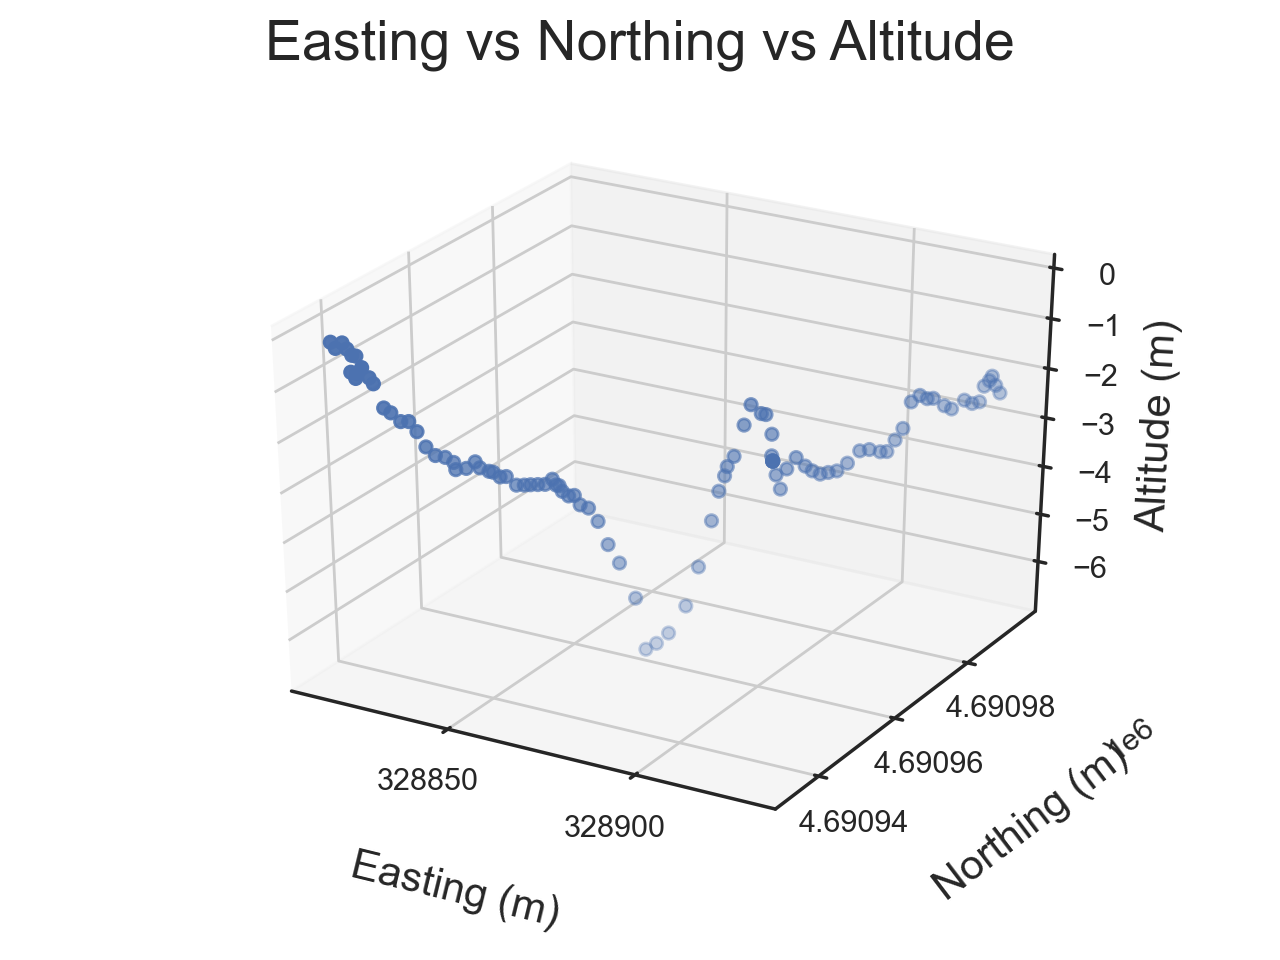

<IPython.core.display.Javascript object>


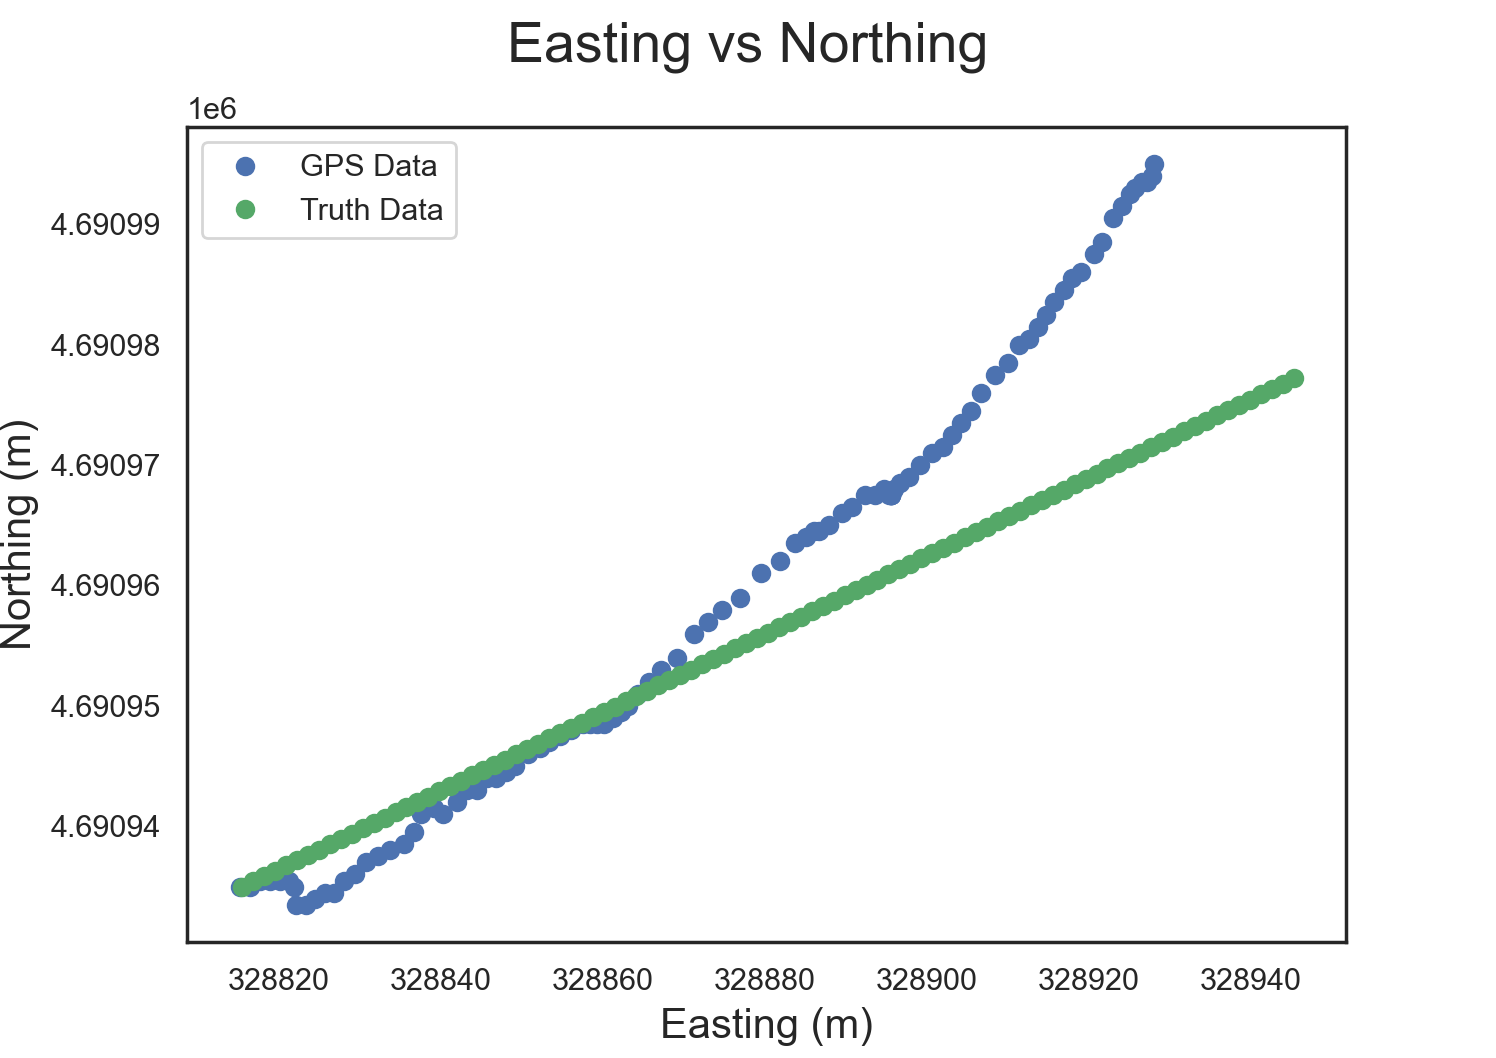

In [37]:
# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')

# Surface plot data
x = dataStat['utm_easting']
y = dataStat['utm_northing']
z = dataStat['altitude']

surf = ax.scatter(x,y,z)
# title and labels, setting initial sizes
fig.suptitle('Easting vs Northing vs Altitude', fontsize=20)
ax.set_xlabel('Easting (m)', fontsize=15, labelpad = 20)
ax.set_ylabel('Northing (m)', fontsize=15, labelpad = 20)   # relative to plt.rcParams['font.size']
ax.set_zlabel('Altitude (m)', fontsize=15)   # relative to plt.rcParams['font.size']
ax.ticklabel_format(useOffset=False)
plt.locator_params(axis="y", nbins=4)
plt.locator_params(axis="x", nbins=4)

# Location over time
fig2 = plt.figure()
ax2 = fig2.gca()
plt.plot(dataStat['utm_easting'], dataStat['utm_northing'], 'bo', label='GPS Data')
plt.plot(dataStat['truth_east'], dataStat['truth_north'], 'go', label='Truth Data')
fig2.suptitle('Easting vs Northing', fontsize=20)
ax2.set_xlabel('Easting (m)', fontsize=15)
ax2.set_ylabel('Northing (m)', fontsize=15)   # relative to plt.rcParams['font.size']
ax2.ticklabel_format(useOffset=False)
ax2.legend()

<IPython.core.display.Javascript object>


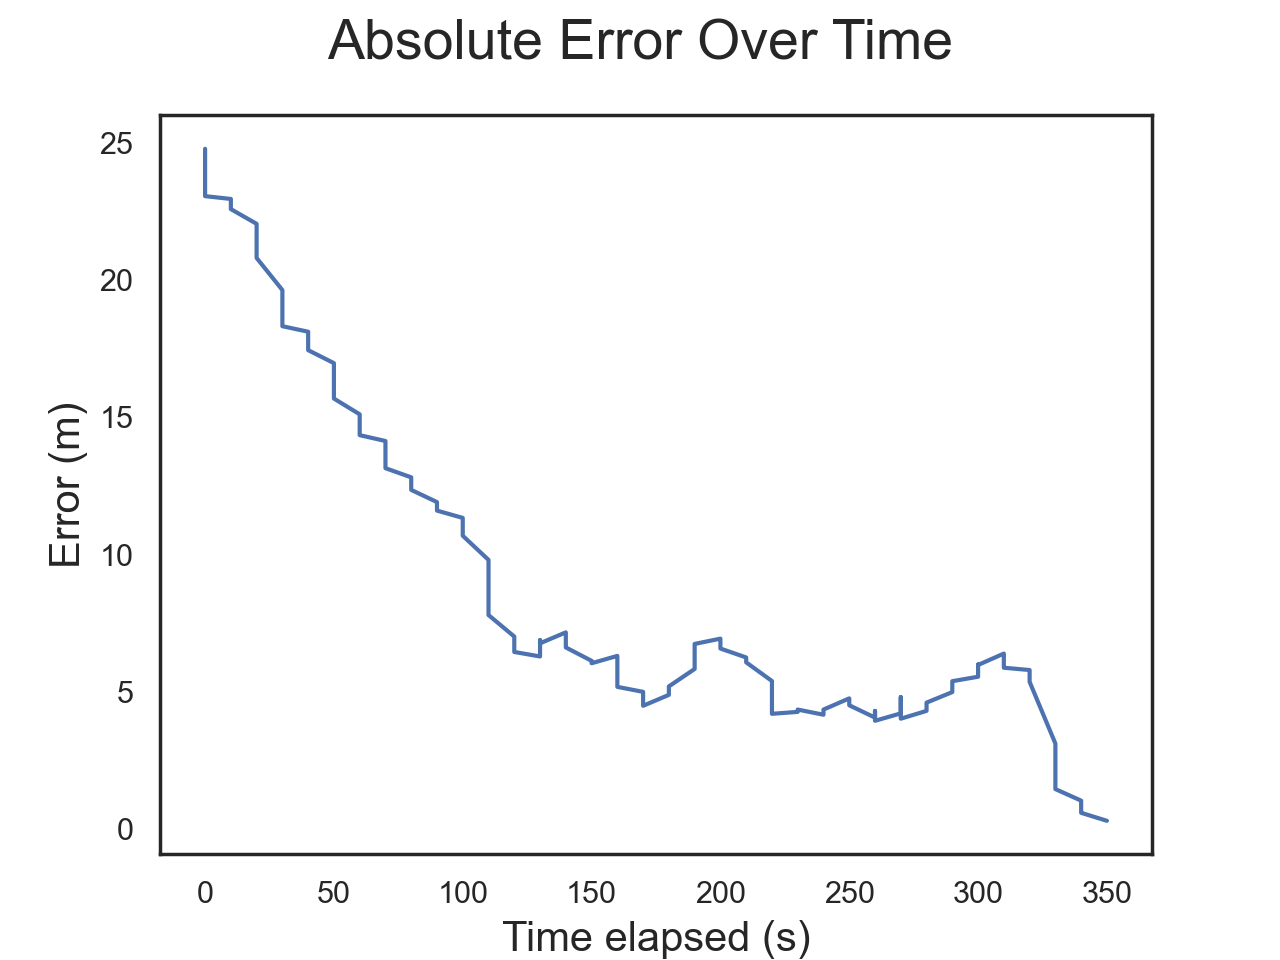

In [36]:
### Error plots
# Absolute error over time
fig3 = plt.figure()
ax3 = fig3.gca()
plt.plot(dataStat['time_elapsed']*10, dataStat['error_abs'])
fig3.suptitle('Absolute Error Over Time', fontsize=20)
ax3.set_xlabel('Time elapsed (s)', fontsize=15)
ax3.set_ylabel('Error (m)', fontsize=15)   # relative to plt.rcParams['font.size']
ax3.ticklabel_format(useOffset=False)

<IPython.core.display.Javascript object>


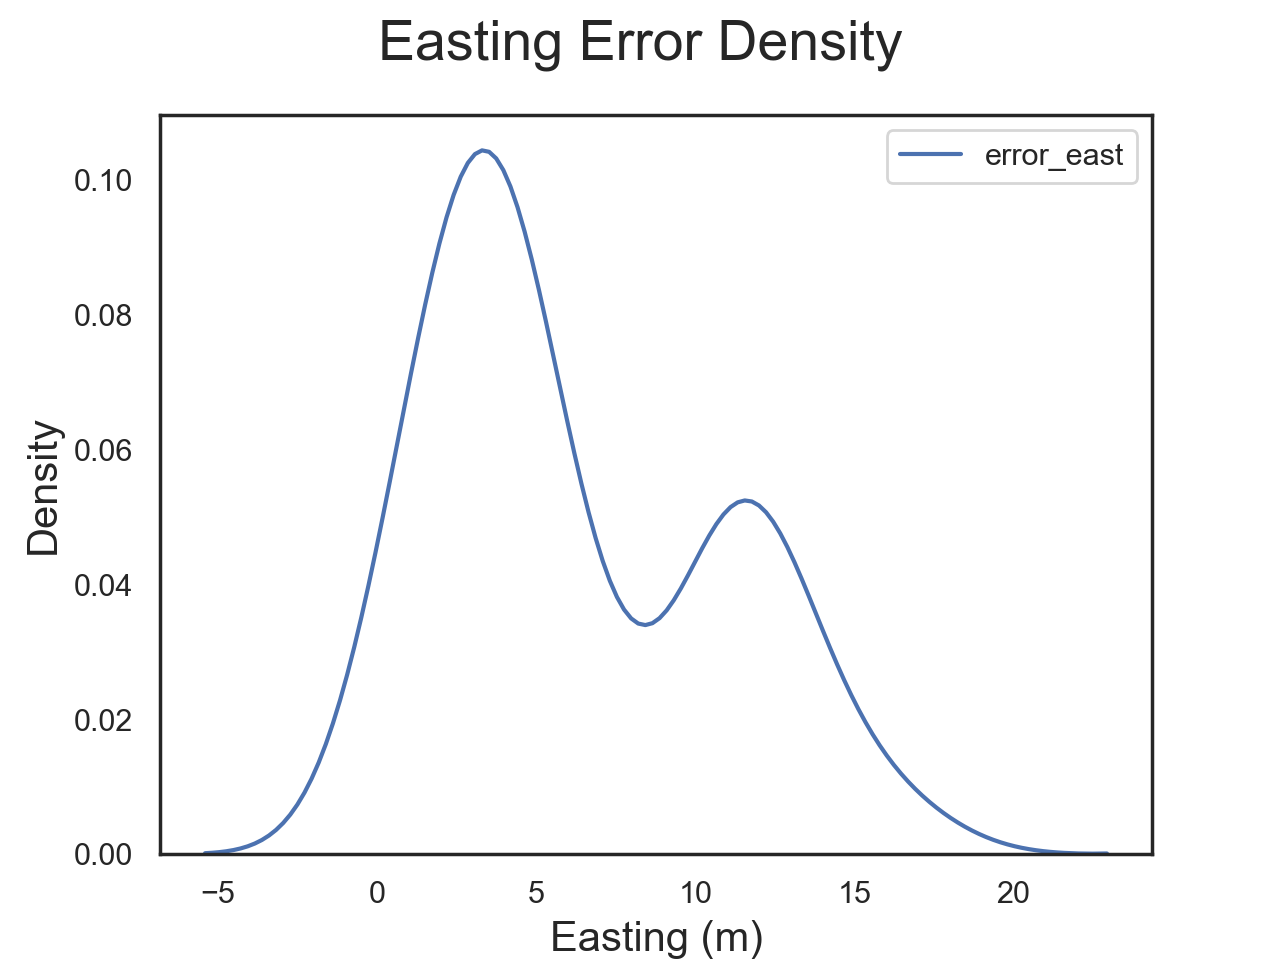

<IPython.core.display.Javascript object>


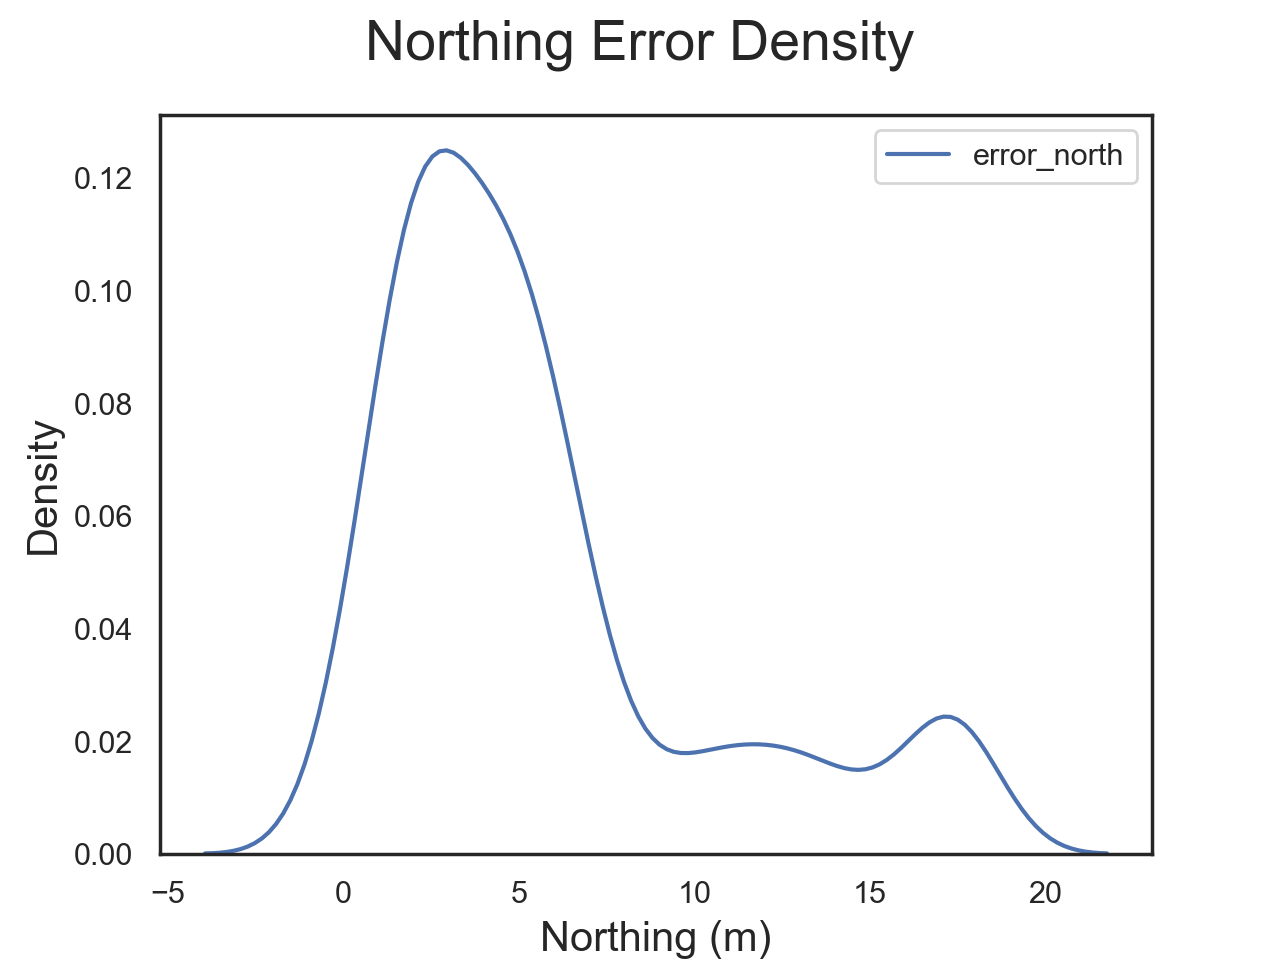

<IPython.core.display.Javascript object>


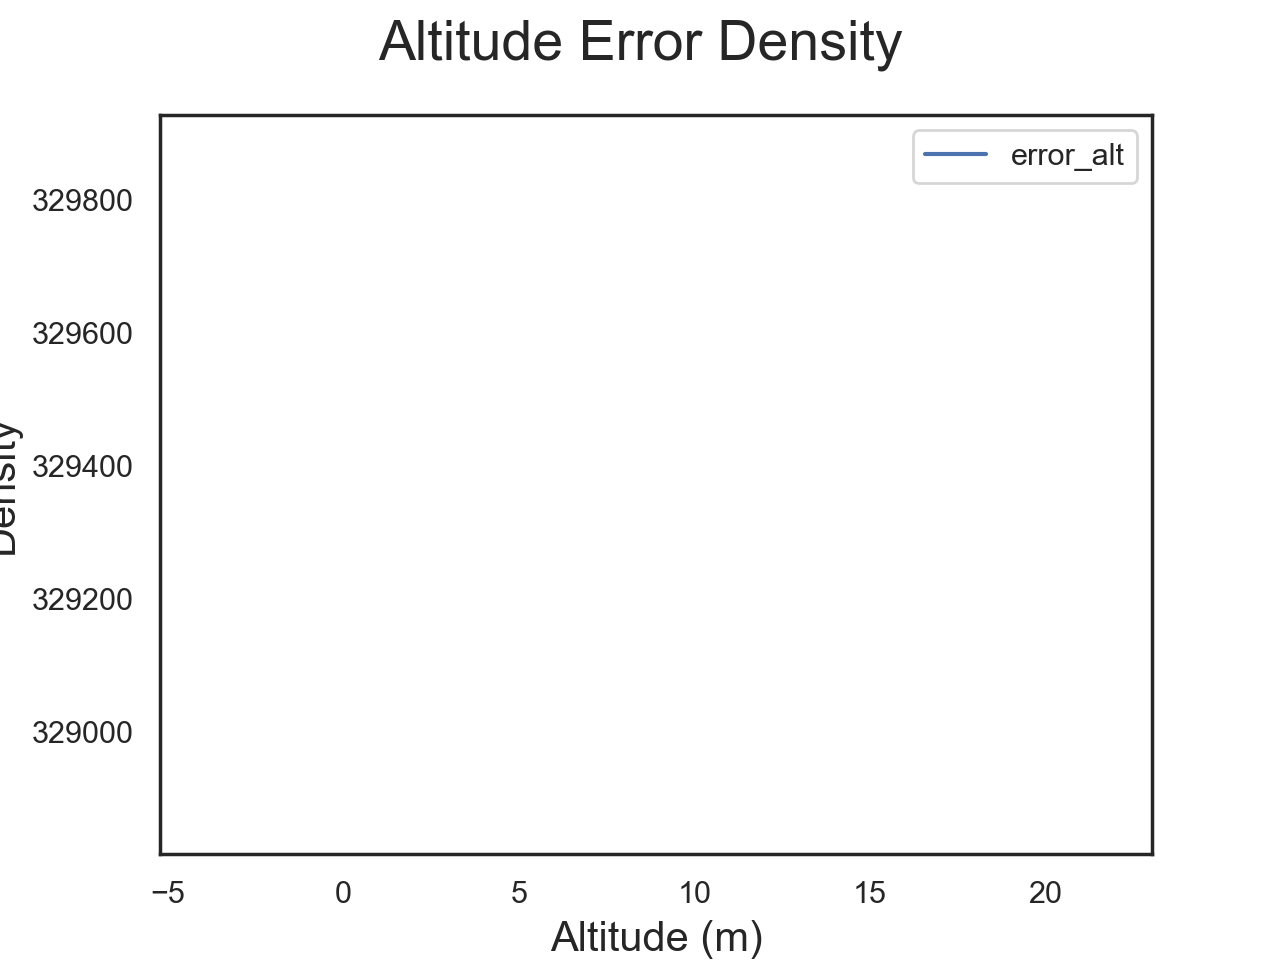

Text(0, 0.5, 'Density')

In [52]:
# Distribution of locations
# Location over time - we would expect this to be a uniform distribution
# Easting
fig2 = plt.figure()
ax2 = fig2.gca()
sns.kdeplot(dataStat['error_east'])
fig2.suptitle('Easting Error Density', fontsize=20)
ax2.set_xlabel('Easting (m)', fontsize=15)
ax2.set_ylabel('Density', fontsize=15)
# Northing
fig2 = plt.figure()
ax2 = fig2.gca()
sns.kdeplot(dataStat['error_north'])
fig2.suptitle('Northing Error Density', fontsize=20)
ax2.set_xlabel('Northing (m)', fontsize=15)
ax2.set_ylabel('Density', fontsize=15)
# Altitude
fig2 = plt.figure()
ax2 = fig2.gca()
sns.kdeplot(dataStat['error_alt'])
fig2.suptitle('Altitude Error Density', fontsize=20)
ax2.set_xlabel('Altitude (m)', fontsize=15)
ax2.set_ylabel('Density', fontsize=15)

<IPython.core.display.Javascript object>


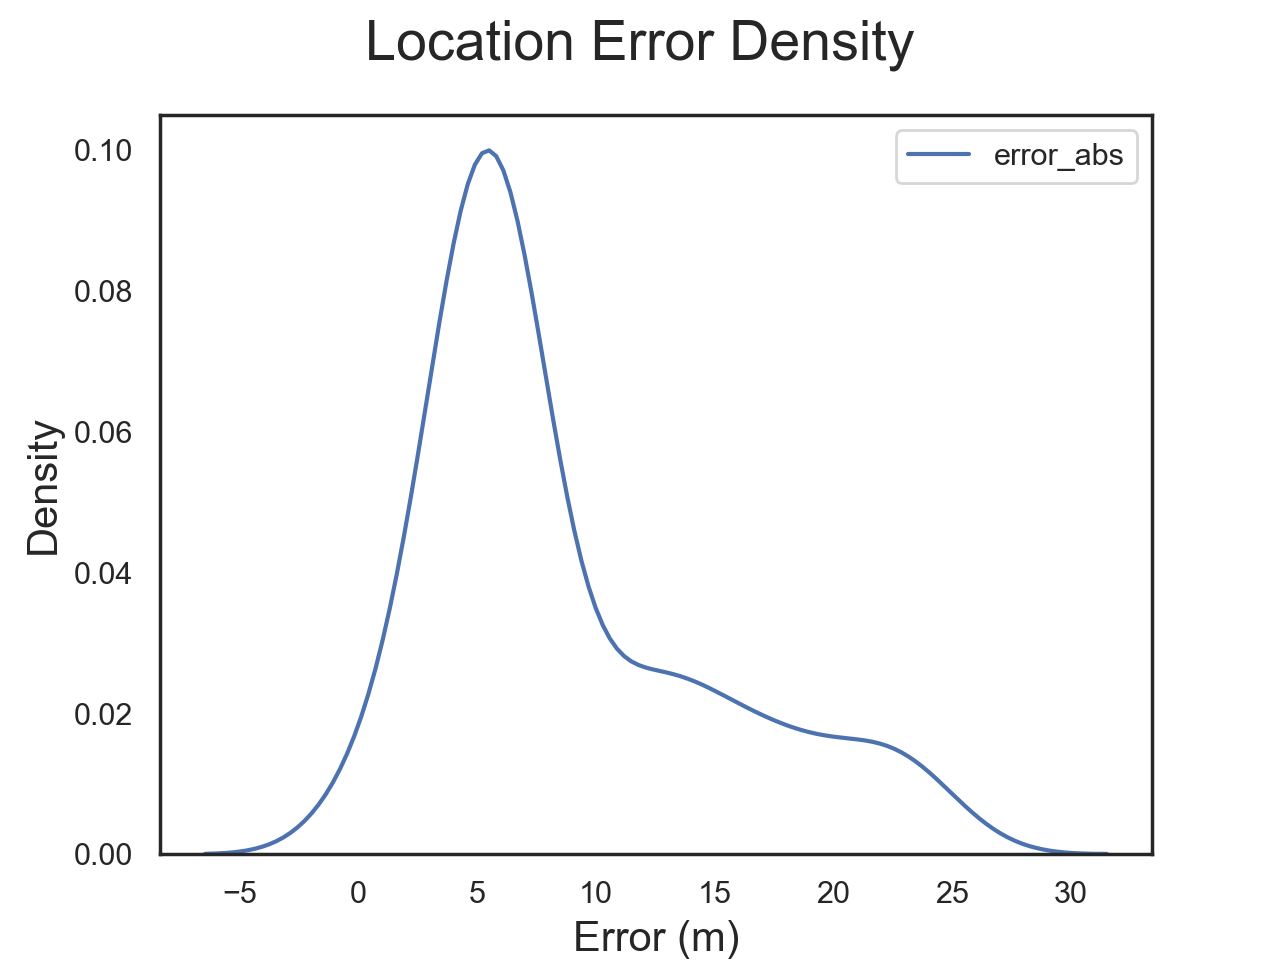

Text(0, 0.5, 'Density')

In [49]:
# Absolute Error
fig2 = plt.figure()
ax2 = fig2.gca()
sns.kdeplot(dataStat['error_abs'])
fig2.suptitle('Location Error Density', fontsize=20)
ax2.set_xlabel('Error (m)', fontsize=15)
ax2.set_ylabel('Density', fontsize=15) 

In [53]:
# 2 dimensional KDE
sns.set(style="white", color_codes=True)
plt.ylim(dataStat['utm_easting'].min(), dataStat['utm_easting'].max() + 1000)
ax = sns.jointplot(
    x=dataStat["error_east"],
    y=dataStat["error_north"],
    kind='kde',
    marginal_kws={'lw':5,
                 'color':'red'})
ax.set_axis_labels('Easting (m)', 'Northing (m)')

<IPython.core.display.Javascript object>

In [55]:
# Print summary statistics
pd.set_option("display.width", 250)
d = dataStat.describe()[['error_abs', 'error_east', 'error_north']]
d.columns = ['Error Euclidean (m)', 'Easting Error (m)', 'Northing Error (m)']
d

Error Euclidean (m)  Easting Error (m)  Northing Error (m)
count      97.000000000000    97.000000000000     97.000000000000
mean        8.771154623812     6.209794531006      5.692846525124
std         6.061191293550     4.476031578898      4.767431239647
min         0.303363218199     0.303292696772      0.006540813483
25%         4.762284650395     3.171982106636      2.345566391014
50%         6.253023655401     4.041910956614      4.372757242993
75%        11.912098749933    10.951739273267      6.537157249637
max        24.780791996613    17.235221365932     17.805470969528